In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import h5py
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
#%matplotlib notebook
%matplotlib inline

plt.rcParams.update({
    "figure.constrained_layout.use" : True,
    "font.size" : 18,
    "legend.fontsize" : "small",
    "figure.figsize" : (7, 5)
})

In [2]:
#path settings
drive_path = "drive/MyDrive/project_Flowers-299/data/"
local_path = "data/"

# set "path = drive path" for running in colab
# set "path = local_path" for running locally (in git repository)
path = local_path

In [3]:
if not os.path.isdir(path + "alternative_approach"):
    os.mkdir(path + "alternative_approach")

# Beispiel: Bild und RGB-Histogramm

(200, 200, 3)


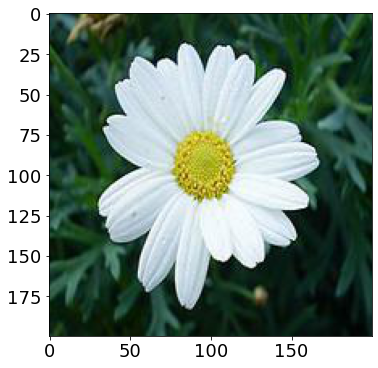

In [4]:
im = np.array(Image.open("example_images/MargueriteDaisy.jpg"))
print(im.shape)

fig = plt.figure()
ax = fig.add_subplot()

ax.imshow(im)
fig.savefig(path + "alternative_approach/example_image.pdf")

(40000,)
(40000,)
(40000,)


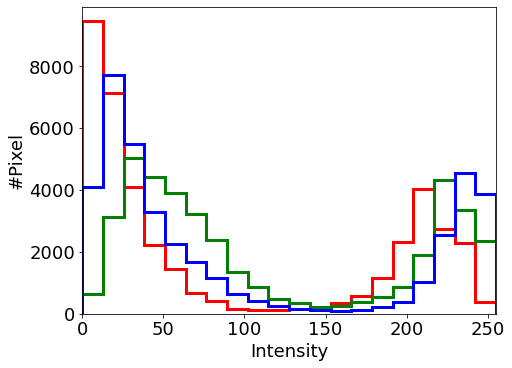

In [5]:
fig = plt.figure()
ax = fig.add_subplot()

for rgb,color in zip((0,1,2),('r', 'g', 'b')):
    bla = im[:,:,rgb].reshape(-1)
    print(bla.shape)
    ax.hist(bla, color=color, bins = 20, alpha= 1, histtype='step', linewidth =3)

ax.set_xlim(0, 255)
ax.set_xlabel("Intensity")
ax.set_ylabel("#Pixel")
fig.savefig(path + "alternative_approach/example_rgb_hist.pdf")

# Train+Val Daten laden und splitten

In [6]:
with h5py.File(path + "images_resized_train.h5", "r") as file:
    X = np.array(file["/images"]).astype("float32")
    y = np.array(file["/labels"]).astype("uint8")

# Split 15% of total data as validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1764, random_state=42, stratify=y)

# 6D Vektoren aus Mean_RGB(3)+Std_RGB(3) erstellen

In [7]:
#RGB Averages
X_avgs_train = np.mean(X_train, axis=(1,2))
X_avgs_val = np.mean(X_val, axis=(1,2))
#RGB Standard Deviations
X_stds_train = np.std(X_train, axis=(1,2))
X_stds_val = np.std(X_val, axis=(1,2))

#6D-Vektoren der Form [Mean_R, Mean_G, Mean_B, Std_R, Std_G, Std_B]
X_6d_train = np.concatenate((X_avgs_train, X_stds_train), axis=1)
X_6d_val = np.concatenate((X_avgs_val, X_stds_val), axis=1)

# 3D-Plot der Punkte (just for fun)

Text(0.5, 0, 'Mean Value B')

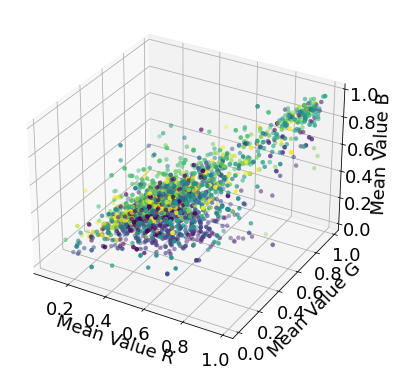

In [8]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(X_avgs_train[:,0], X_avgs_train[:,1], X_avgs_train[:,2], c=y_train, linewidths = 0.001)
ax.set_xlabel("Mean Value R")
ax.set_ylabel("Mean Value G")
ax.set_zlabel("Mean Value B")

# Accuracy bestimmen (kNN)

## Test-Daten laden + 6D-Vektoren erstellen

In [9]:
#Testdatensatz laden + RGB auslesen

#Laden
with h5py.File(path + "images_resized_test.h5", "r") as file:
    X_test = np.array(file["/images"]).astype("float32")
    y_test = np.array(file["/labels"]).astype("uint8")
    
#RGB
X_avgs_test = np.mean(X_test, axis=(1,2))
X_stds_test = np.std(X_test, axis=(1,2))
X_6d_test = np.concatenate((X_avgs_test, X_stds_test), axis=1)

## Accuracy auf Test-Datensatz (mean+std 6D)

### Bestimmung des besten $k$ mit $k_\text{max} = 300$ ( mean+std 6D)

Best k:  81
Erreichte Accuracy:  0.39019963702359345


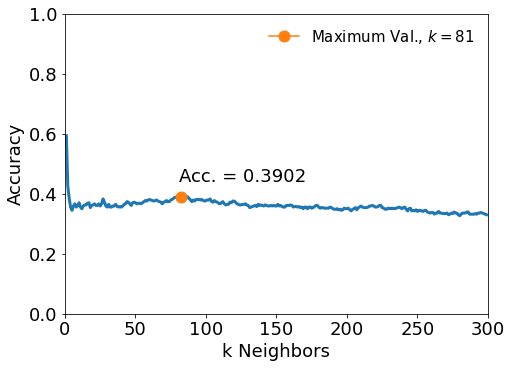

In [10]:
acc = []

ks = np.arange(1,300,1)
#ks = np.append(ks, np.arange(200,1000,100)) #Tendenz

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_6d_train, y_train)
    acc.append( knn.score(X_6d_val, y_val) )

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(ks, acc, linewidth=3)
ax.plot(ks[np.argmax(acc[2:]) + 2], acc[np.argmax(acc[2:]) + 2], marker='o', markersize=11, label = r"Maximum Val., $k=81$")
ax.set_xlabel("k Neighbors")
ax.set_ylabel("Accuracy")
ax.set_xlim(0,300)
ax.set_ylim(0,1)
ax.legend(frameon=False)
ax.text(81, 0.44, "Acc. = "+str(np.round(acc[np.argmax(acc[2:]) + 2], decimals=4)))

print("Best k: ", np.argmax(acc[2:]) + 2)
print("Erreichte Accuracy: ", acc[np.argmax(acc[2:]) + 2])
fig.savefig(path + "alternative_approach/accuracy_knn_threshold_300.pdf")

#best k acquired through argmax of accuracy
#k = 0 and 1 are skipped, because this seems to be a result of copy of images in train and test set

### Trend der Accuracy für $k_\text{max} = 1000$

Best k:  81
Erreichte Accuracy:  0.39019963702359345


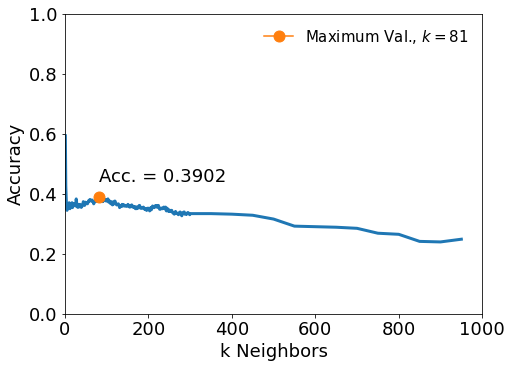

In [11]:
acc = []

ks = np.arange(1,300,1)
ks = np.append(ks, np.arange(300,1000,50)) #Tendenz

for k in ks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_6d_train, y_train)
    acc.append( knn.score(X_6d_val, y_val) )

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(ks, acc, linewidth=3)
ax.plot(ks[np.argmax(acc[2:]) + 2], acc[np.argmax(acc[2:]) + 2], marker='o', markersize=11, label = r"Maximum Val., $k=81$")
ax.set_xlabel("k Neighbors")
ax.set_ylabel("Accuracy")
ax.set_xlim(0,1000)
ax.set_ylim(0,1)
ax.legend(frameon=False)
ax.text(81, 0.44, "Acc. = "+str(np.round(acc[np.argmax(acc[2:]) + 2], decimals=4)))

print("Best k: ", np.argmax(acc[2:]) + 2)
print("Erreichte Accuracy: ", acc[np.argmax(acc[2:]) + 2])
fig.savefig(path + "alternative_approach/accuracy_knn_threshold_1000.pdf")

#best k acquired through argmax of accuracy
#k = 0 and 1 are skipped, because this seems to be a result of copy of images in train and test set

### Auswertung: Test Accuracy

In [12]:
best_k = np.argmax(acc[2:]) + 2

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_6d_train, y_train)

acc_test = np.round(knn.score(X_6d_test, y_test),decimals=4)

print("Erreichte Test-Accuracy: ", acc_test)

Erreichte Test-Accuracy:  0.3696


 ### Ergebnis: Accuracy = 0.3696 (mean+std 6D)